In [282]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

Define the "value" class, which essentially encodes data and label attributes. Each value object will basically be one node in the simple neural network.

In [283]:
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

        #Instruction (function) on how to locally differentiate
        self._backward = lambda: None

    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        
        #Make sure that we can add floats and integers to value objects
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        #Set attribute as a function rather than output of a function
        out._backward = _backward

        return out
    
    def __mul__(self, other):

        #Make sure that we can multiply floats and integers to value objects
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        #Set attribute as a function rather than output of a function
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def tanh(self):
        n = self.data
        t = (np.exp(2*n) - 1) / (np.exp(2*n) + 1)

        out = Value(t, (self, ), _op = 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
        #Set attribute as a function rather than output of a function
        out._backward = _backward

        return out

    def backwards(self):
        """Version of backwards pass which implements topological sort."""

        #Sets neuron to output
        self.grad = 1.0

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                #Root will be the last neuron in the topo list
                topo.append(v)
        
        build_topo(self)

        for n in reversed(topo):
            #Call the backwards pass for each node starting at the root
            n._backward()

In [285]:
a = Value(2.0, label='a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'

f = Value(-2.0)
f.label = 'f'

L = d*f
L.label = 'L'

In [286]:
#dL/dL = 1
L.grad = 1.0

In [287]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [288]:
d._op

'+'

In [289]:
from graphviz import Digraph

In [290]:
def trace(root):
    """Build set of all nodes and edges in a graph. Returns nodes, edges as sets"""
    nodes, edges = set(), set()
    
    def build(v):
        """Build function which checks to see which nodes have not yet been visited"""
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                #Recursively call build function on child nodes
                build(child) 
    #Call build function on root node            
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) #LR is left-to-right
    
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        #All values in the graph have a labelled node created for them
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')

        #Check to see whether there is an operator involved in the creation of a new node
        if n._op:
            dot.node(name = uid + n._op, label = n._op)

            #Connect the nodes
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [291]:
f.grad = d.data
d.grad = f.data

c.grad = d.grad
e.grad = d.grad

a.grad = e.grad * b.data
b.grad = e.grad * a.data

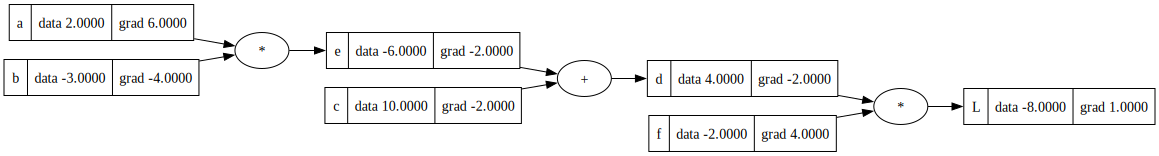

In [292]:
draw_dot(L)

In [293]:
#################
# FORWARDS PASS #
#################

#More complex neural net, using inputs or 'features' x1 and x2

#Features (e.g. price of house, location of house)
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0,label = 'x2')

#Weights (how much each of these features matters in the model we are building)
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0,label = 'w2')

#Neuron bias
b = Value(6.881373587, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1plusx2w2 = x1w1 + x2w2; x1w1plusx2w2.label = 'x1w1 + x2w2'

#Neuron
n = x1w1plusx2w2 + b; n.label = 'n'

#Activation function producing sigmoid output o
o = n.tanh()
o.label = 'o'


In [294]:
##################
# BACKWARDS PASS #
##################

o.backwards()

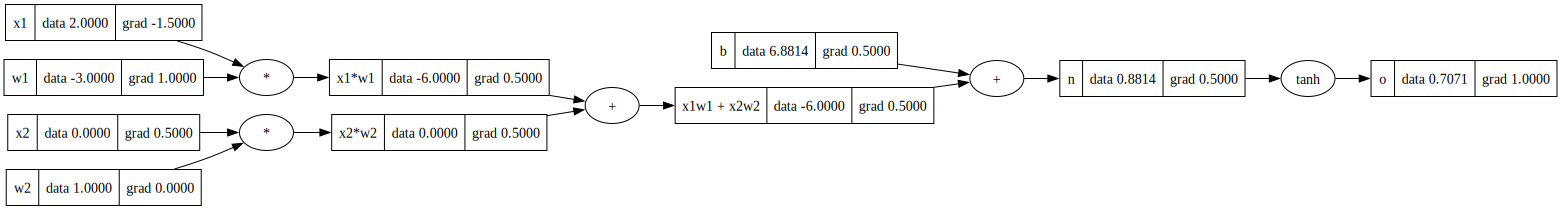

In [295]:
draw_dot(o)